This notebook contains the code used in the BigComp 2022 paper:
Heeryon Cho, Woo-Kyu Kang, Younsoo Park, Sungeu Chae, and Seong-joon Kim, "Multi-label Facial Emotion Recognition Using Korean Drama Movie Clips," BigComp 2022.

### Convolutional Neural Network (CNN) / Classify Multi-label Emotions

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rn
import os

In [2]:
import warnings
import logging
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Record cell run time.
#!pip install ipython-autotime

%load_ext autotime

time: 224 µs (started: 2021-12-07 10:48:36 +00:00)


In [4]:
# Set seed for reproducibility.

set_seed = 46
np.random.seed(set_seed)
rn.seed(set_seed)
tf.random.set_seed(set_seed)

time: 1.48 ms (started: 2021-12-07 10:48:36 +00:00)


### Load label data.

In [5]:
# Load labels, check headers, check data shape.

df_label = pd.read_csv('label/label_multi-label.csv')
print(df_label.columns)
print(df_label.shape)

LABELS = list(df_label.columns[2:])
print("LABELS=", LABELS)
print("All classes:", len(LABELS))

label_valid = pd.read_csv('label/label_multi-label_valid.csv')
label_train = pd.read_csv('label/label_multi-label_train.csv')
label_test = pd.read_csv('label/label_multi-label_test.csv')

VALID_DATA_SIZE = label_valid.shape[0]
TRAIN_DATA_SIZE = label_train.shape[0]
TEST_DATA_SIZE = label_test.shape[0]

print("TRAIN_DATA_SIZE:", label_train.shape[0])
print("VALID_DATA_SIZE:", label_valid.shape[0])
print("TEST_DATA_SIZE:", label_test.shape[0])

Index(['img_id', 'clip_id', 'moved', 'fearful', 'bored', 'surprised', 'angry',
       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
       'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful',
       'happy', 'disgusted'],
      dtype='object')
(38817, 26)
LABELS= ['moved', 'fearful', 'bored', 'surprised', 'angry', 'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled', 'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed', 'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful', 'happy', 'disgusted']
All classes: 24
TRAIN_DATA_SIZE: 31053
VALID_DATA_SIZE: 3882
TEST_DATA_SIZE: 3882
time: 162 ms (started: 2021-12-07 10:48:36 +00:00)


### Define training pipeline.

In [6]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
import nvidia.dali.plugin.tf as dali_tf

class TFRecordPipelineTrain(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTrain, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = ['./tfrecords/multi-label_train.tfrecords'],
             index_path = ['./tfrecords/multi-label_train.idx'],
             random_shuffle=True,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 90.1 ms (started: 2021-12-07 10:48:36 +00:00)


### Define validation pipeline.

In [7]:
class TFRecordPipelineValid(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineValid, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = ['./tfrecords/multi-label_valid.tfrecords'],
             index_path = ['./tfrecords/multi-label_valid.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.74 ms (started: 2021-12-07 10:48:36 +00:00)


### Train CNN model for classifying multi-label emotions.

In [8]:
if __name__ == "__main__":
    batch_size = 64
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 24))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)

    batch_size_valid = 64
    shapes_valid = ((batch_size_valid, 64, 64, 3),
                    (batch_size_valid, 24))
    pipe_valid = TFRecordPipelineValid(batch_size=batch_size_valid, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)   
    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)

        ds_valid = dali_tf.DALIDataset(
            pipeline=pipe_valid,
            batch_size=batch_size_valid,
            output_shapes=shapes_valid,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)  
      
        initializer = keras.initializers.GlorotUniform(seed=set_seed)
        activation =  keras.activations.sigmoid
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-5,
            decay_steps=TRAIN_DATA_SIZE // batch_size * 10,
            decay_rate=0.95)        
        
        number_of_classes = 24
        
        inputs = keras.Input(shape=(64, 64, 3))
        conv1 = keras.layers.Conv2D(128,(5, 5), padding='same', activation='relu')(inputs)
        do1 = keras.layers.Dropout(0.5, seed=set_seed)(conv1)         
        conv2 = keras.layers.Conv2D(64,(5, 5), padding='same', activation='relu')(do1)
        do2 = keras.layers.Dropout(0.5, seed=set_seed)(conv2)         
        conv3 = keras.layers.Conv2D(32,(5, 5), padding='same', activation='relu')(do2)
        do3 = keras.layers.Dropout(0.5, seed=set_seed)(conv3)       
        flatten = keras.layers.Flatten()(do3)   
        outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(flatten) 
        clf = keras.Model(inputs, outputs)
        
        clf.summary()

        # Apply early stopping.        
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                       restore_best_weights=True)          
       
        clf.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])
        
        history = clf.fit(ds_train, steps_per_epoch=TRAIN_DATA_SIZE // batch_size, 
                          validation_data=ds_valid.take(VALID_DATA_SIZE // batch_size_valid),
                          epochs=1000,
                          callbacks=[es_callback])      

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 128)       9728      
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        204864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        51232     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 32)        0     

485/485 [==============================] - 11s 22ms/step - loss: 0.0827 - accuracy: 0.5637 - val_loss: 0.0935 - val_accuracy: 0.5349
Epoch 47/1000
485/485 [==============================] - 11s 22ms/step - loss: 0.0813 - accuracy: 0.5692 - val_loss: 0.0930 - val_accuracy: 0.5378
Epoch 48/1000
485/485 [==============================] - 11s 22ms/step - loss: 0.0799 - accuracy: 0.5715 - val_loss: 0.0921 - val_accuracy: 0.5344
Epoch 49/1000
485/485 [==============================] - 11s 22ms/step - loss: 0.0792 - accuracy: 0.5736 - val_loss: 0.0909 - val_accuracy: 0.5302
Epoch 50/1000
485/485 [==============================] - 11s 22ms/step - loss: 0.0777 - accuracy: 0.5744 - val_loss: 0.0905 - val_accuracy: 0.5354
Epoch 51/1000
485/485 [==============================] - 11s 22ms/step - loss: 0.0768 - accuracy: 0.5786 - val_loss: 0.0901 - val_accuracy: 0.5440
Epoch 52/1000
485/485 [==============================] - 11s 22ms/step - loss: 0.0758 - accuracy: 0.5790 - val_loss: 0.0895 - val_ac

Epoch 102/1000
485/485 [==============================] - 11s 22ms/step - loss: 0.0444 - accuracy: 0.6458 - val_loss: 0.0740 - val_accuracy: 0.5690
Epoch 103/1000
485/485 [==============================] - 11s 22ms/step - loss: 0.0440 - accuracy: 0.6477 - val_loss: 0.0737 - val_accuracy: 0.5674
Epoch 104/1000
485/485 [==============================] - 11s 22ms/step - loss: 0.0435 - accuracy: 0.6497 - val_loss: 0.0734 - val_accuracy: 0.5690
Epoch 105/1000
485/485 [==============================] - 11s 22ms/step - loss: 0.0431 - accuracy: 0.6482 - val_loss: 0.0735 - val_accuracy: 0.5685
Epoch 106/1000
485/485 [==============================] - 11s 22ms/step - loss: 0.0431 - accuracy: 0.6471 - val_loss: 0.0735 - val_accuracy: 0.5740
Epoch 107/1000
485/485 [==============================] - 11s 22ms/step - loss: 0.0424 - accuracy: 0.6521 - val_loss: 0.0732 - val_accuracy: 0.5688
Epoch 108/1000
485/485 [==============================] - 11s 22ms/step - loss: 0.0426 - accuracy: 0.6475 - val_

In [9]:
# List all data in history.

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
time: 638 µs (started: 2021-12-07 11:15:44 +00:00)


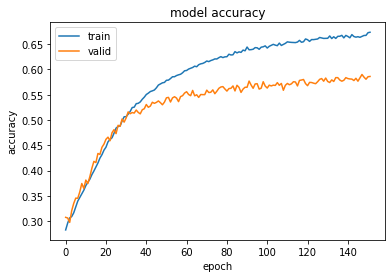

time: 213 ms (started: 2021-12-07 11:15:44 +00:00)


In [10]:
# Summarize history for accuracy.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

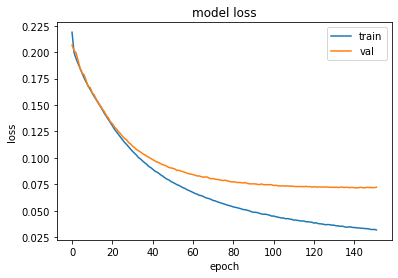

time: 150 ms (started: 2021-12-07 11:15:44 +00:00)


In [11]:
# Summarize history for loss.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Define test pipeline.

In [12]:
class TFRecordPipelineTest(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTest, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = ['./tfrecords/multi-label_test.tfrecords'],
             index_path = ['./tfrecords/multi-label_test.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.89 ms (started: 2021-12-07 11:15:44 +00:00)


### Check test data accuracy.

In [13]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 24))
    pipe_test = TFRecordPipelineTest(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
    #with strategy.scope():        
        # Create dataset
        ds_test = dali_tf.DALIDataset(
            pipeline=pipe_test,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        print(ds_test)
        loss, acc = clf.evaluate(ds_test, steps=TEST_DATA_SIZE)
        print("Test accuracy:", acc)
        predictions = clf.predict(ds_test.take(5))
        print("A test output from the last layer:", predictions[0])
        print("Index of the maximum value:", np.argmax(predictions[0]))
        print("Label:", LABELS[np.argmax(predictions[0])])

<DALIDataset shapes: ((1, 64, 64, 3), (1, 24)), types: (tf.float32, tf.int64)>
3882/3882 [==============================] - 21s 5ms/step - loss: 0.0682 - accuracy: 0.6061
Test accuracy: 0.606130838394165
A test output from the last layer: [1.7845138e-14 5.4248648e-07 1.3473613e-32 1.5023798e-02 1.2129932e-04
 5.5551818e-06 3.3501708e-06 4.6319892e-07 7.5123592e-07 4.1929221e-10
 2.6213532e-17 5.0499834e-02 9.9431205e-01 6.1369947e-06 1.2279854e-24
 3.2687569e-01 9.7859186e-08 3.9467153e-07 1.8556879e-05 7.1484659e-19
 6.5860212e-10 1.3962802e-17 2.1574854e-04 3.6818907e-08]
Index of the maximum value: 12
Label: upset
time: 20.9 s (started: 2021-12-07 11:15:44 +00:00)


In [14]:
predictions

array([[1.78451377e-14, 5.42486475e-07, 1.34736132e-32, 1.50237978e-02,
        1.21299323e-04, 5.55518181e-06, 3.35017080e-06, 4.63198916e-07,
        7.51235916e-07, 4.19292212e-10, 2.62135323e-17, 5.04998341e-02,
        9.94312048e-01, 6.13699467e-06, 1.22798536e-24, 3.26875687e-01,
        9.78591856e-08, 3.94671531e-07, 1.85568788e-05, 7.14846590e-19,
        6.58602117e-10, 1.39628021e-17, 2.15748543e-04, 3.68189070e-08],
       [2.84890112e-09, 2.26739416e-04, 2.47562597e-24, 4.06175241e-04,
        4.35661059e-04, 6.81737840e-01, 4.62038145e-07, 1.16446072e-05,
        1.28189079e-03, 2.01959315e-15, 1.31352226e-05, 6.69757873e-02,
        2.49310769e-02, 9.84710695e-08, 1.20489436e-26, 5.24288684e-04,
        2.77279206e-02, 9.33531851e-07, 1.63904659e-03, 2.13664993e-15,
        7.92732635e-07, 4.44893167e-12, 5.10839466e-03, 7.47908734e-06],
       [2.09295931e-11, 8.14947014e-13, 1.25577469e-30, 9.39604288e-05,
        1.19693294e-01, 1.51922301e-04, 1.74770733e-07, 5.3400

time: 3.94 ms (started: 2021-12-07 11:16:05 +00:00)


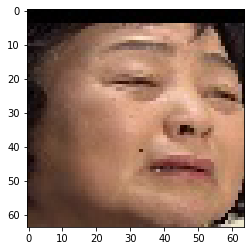

time: 193 ms (started: 2021-12-07 11:16:05 +00:00)


In [15]:
# Display the tested image.

import matplotlib.pyplot as plt

data, = ds_test.take(1)
plt.imshow(data[0][0])

In [16]:
# Check the test data's true label.
data[1]

<tf.Tensor: shape=(1, 24), dtype=int64, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])>

time: 2.75 ms (started: 2021-12-07 11:16:05 +00:00)


In [17]:
### Result: Argmax Accuracy & Micro F1-score

time: 4.66 ms (started: 2021-12-07 11:16:05 +00:00)


In [18]:
pred_test = clf.predict(ds_test.take(TEST_DATA_SIZE))

time: 12.3 s (started: 2021-12-07 11:16:05 +00:00)


In [19]:
true_test = np.concatenate([y for x, y in ds_test.take(TEST_DATA_SIZE)], axis=0)

time: 1.41 s (started: 2021-12-07 11:16:18 +00:00)


In [20]:
true_test.shape

(3882, 24)

time: 2.6 ms (started: 2021-12-07 11:16:19 +00:00)


In [21]:
from sklearn.metrics import accuracy_score, f1_score

true_test_ls = []
pred_test_ls = []

for (true, pred) in zip(true_test, pred_test):
    true_test_ls.append(np.argmax(true))
    pred_test_ls.append(np.argmax(pred))

argmax_acc = accuracy_score(true_test_ls, pred_test_ls)
f1_micro = f1_score(true_test_ls, pred_test_ls, average='micro')

print("argmax accuracy:", argmax_acc)
print("f1_micro:", f1_micro)

argmax accuracy: 0.6061308603812467
f1_micro: 0.6061308603812467
time: 434 ms (started: 2021-12-07 11:16:19 +00:00)


In [22]:
### Result: Threshold=0.5 Accuracy & Micro F1-score

time: 287 µs (started: 2021-12-07 11:16:20 +00:00)


In [23]:
pred_05 = pred_test.copy()
pred_05

array([[1.7845138e-14, 5.4248648e-07, 1.3473613e-32, ..., 1.3962802e-17,
        2.1574854e-04, 3.6818907e-08],
       [2.8489011e-09, 2.2673942e-04, 2.4756260e-24, ..., 4.4489317e-12,
        5.1083947e-03, 7.4790873e-06],
       [2.0929593e-11, 8.1494701e-13, 1.2557747e-30, ..., 2.4420216e-11,
        2.5164747e-08, 6.5367149e-06],
       ...,
       [3.2484158e-11, 1.7965787e-15, 9.4863014e-35, ..., 4.7793208e-08,
        2.1064534e-07, 5.1592296e-11],
       [1.7019466e-06, 9.9877876e-01, 2.9815326e-23, ..., 3.4558769e-11,
        3.4597480e-05, 2.8817269e-05],
       [2.4636336e-06, 5.4651500e-10, 3.8468305e-27, ..., 1.1229651e-07,
        4.9137385e-03, 3.4955049e-12]], dtype=float32)

time: 6.71 ms (started: 2021-12-07 11:16:20 +00:00)


In [24]:
for ls in pred_05:
    thres = 0.5
    pred_05[pred_05 >= thres] = 1
    pred_05[pred_05 < thres] = 0
pred_05[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.4 s (started: 2021-12-07 11:16:20 +00:00)


In [25]:
accuracy_score(true_test, pred_05)

0.6803194229778464

time: 8.64 ms (started: 2021-12-07 11:16:21 +00:00)


In [26]:
f1_score(true_test, pred_05, average='micro')

0.8333034272384712

time: 25.5 ms (started: 2021-12-07 11:16:21 +00:00)


In [27]:
### Result: Threshold=0.4 Accuracy & Micro F1-score

time: 256 µs (started: 2021-12-07 11:16:21 +00:00)


In [28]:
pred_04 = pred_test.copy()
for ls in pred_04:
    thres = 0.4
    pred_04[pred_04 >= thres] = 1
    pred_04[pred_04 < thres] = 0
pred_04[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.44 s (started: 2021-12-07 11:16:21 +00:00)


In [29]:
accuracy_score(true_test, pred_04)

0.6764554353426069

time: 8.43 ms (started: 2021-12-07 11:16:23 +00:00)


In [30]:
f1_score(true_test, pred_04, average='micro')

0.8306039338012304

time: 25.4 ms (started: 2021-12-07 11:16:23 +00:00)


In [31]:
### Result: Threshold=0.3 Accuracy & Micro F1-score

time: 259 µs (started: 2021-12-07 11:16:23 +00:00)


In [32]:
pred_03 = pred_test.copy()
for ls in pred_03:
    thres = 0.3
    pred_03[pred_03 >= thres] = 1
    pred_03[pred_03 < thres] = 0
pred_03[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.5 s (started: 2021-12-07 11:16:23 +00:00)


In [33]:
accuracy_score(true_test, pred_03)

0.6530139103554868

time: 8.31 ms (started: 2021-12-07 11:16:24 +00:00)


In [34]:
f1_score(true_test, pred_03, average='micro')

0.822706842017646

time: 25.7 ms (started: 2021-12-07 11:16:24 +00:00)


In [35]:
### Result: Threshold=0.2 Accuracy & Micro F1-score

time: 256 µs (started: 2021-12-07 11:16:24 +00:00)


In [36]:
pred_02 = pred_test.copy()
for ls in pred_02:
    thres = 0.2
    pred_02[pred_02 >= thres] = 1
    pred_02[pred_02 < thres] = 0
pred_02[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.57 s (started: 2021-12-07 11:16:24 +00:00)


In [37]:
accuracy_score(true_test, pred_02)

0.6081916537867079

time: 8.31 ms (started: 2021-12-07 11:16:26 +00:00)


In [38]:
f1_score(true_test, pred_02, average='micro')

0.8069205245694423

time: 27.4 ms (started: 2021-12-07 11:16:26 +00:00)


In [39]:
### Result: Threshold=0.1 Accuracy & Micro F1-score

time: 257 µs (started: 2021-12-07 11:16:26 +00:00)


In [40]:
pred_01 = pred_test.copy()
for ls in pred_01:
    thres = 0.1
    pred_01[pred_01 >= thres] = 1
    pred_01[pred_01 < thres] = 0
pred_01[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.71 s (started: 2021-12-07 11:16:26 +00:00)


In [41]:
accuracy_score(true_test, pred_01)

0.48815043791859863

time: 8.4 ms (started: 2021-12-07 11:16:28 +00:00)


In [42]:
f1_score(true_test, pred_01, average='micro')

0.7612745450622168

time: 28.9 ms (started: 2021-12-07 11:16:28 +00:00)
